# Talbot Image Processing

In this section, we'll take a Talbot image and attempt to take the Fourier transform.

In [1]:
import numpy as np
from scipy import signal
from skimage import filters
import matplotlib.pyplot as plt
from PIL import Image

### view and crop image

(4656, 3496)
(3970, 2495)


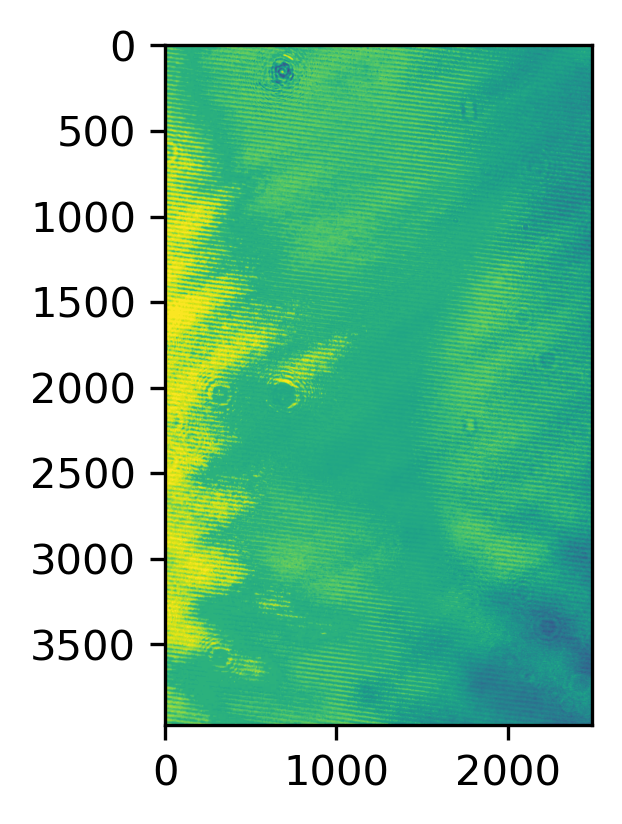

In [145]:
xmin = 1000
xmax = 3495
ymin = 30
ymax = 4000

path = r"C:\Users\jade2\Dropbox (Personal)\Courses\QuantumLab\Project_MOT\data\HeNe_20240502_14_35_22_ChangedAssembly.jpg"
img = np.mean(np.asarray(Image.open(path)), axis=2).transpose()
print(img.shape)
img = img[ymin:ymax, xmin:xmax]

print(img.shape)
plt.figure(figsize=(3,3), dpi=300)
implot = plt.imshow(img)

### 2D FFT and Bandpass
There's lots of spurious low-frequency stuff in a lot of our images. Let's try to remove it using Fourier filtering.

In [ ]:
# def gauss(shape, varx, vary, x0, y0):
#     xx, yy = np.mgrid[0:shape[0], 0:shape[1]]
#     out = np.exp(- (xx-x0)**2 / (2*varx) - (yy-y0)**2 / (2*vary))
#     return out

# ftim = np.fft.fft2(img)
# fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(3,3), dpi=300)

# # Plot FFT
# #ax1.imshow(np.log(np.abs(ftim)))

# # Plot Gaussian masked FFT
# masked = ftim * gauss(ftim.shape, 1e5, 1e5, 0, 0)
# ax2.imshow(np.log(np.abs(masked) + 1))

# # IFFT
# invert = np.fft.ifft2(masked)
# invert = invert - np.mean(invert)
# ax3.imshow(np.abs(invert))

# plt.show()

### test filter parameters
(deprecated)

In [ ]:
# ### prefer bandpass in 2D Fourier domain
# low = 12
# high = img.shape[0] // 4
# print(low)
# print(high)
# b, a = signal.butter(5, [low, high], fs=img.shape[0], btype='band')
# sigs = []
# for i in range(img.shape[1]):
#     sigs.append(signal.lfilter(b, a, img[:, i]))
# plt.figure(figsize=(6,6), dpi=300)
# plt.xlim(0, 500)
# plt.ylim(0, 500)
# plt.imshow(np.vstack(sig))

### using scikit-image filters
Let's see if something someone who actually knows what they're doing built will work better.

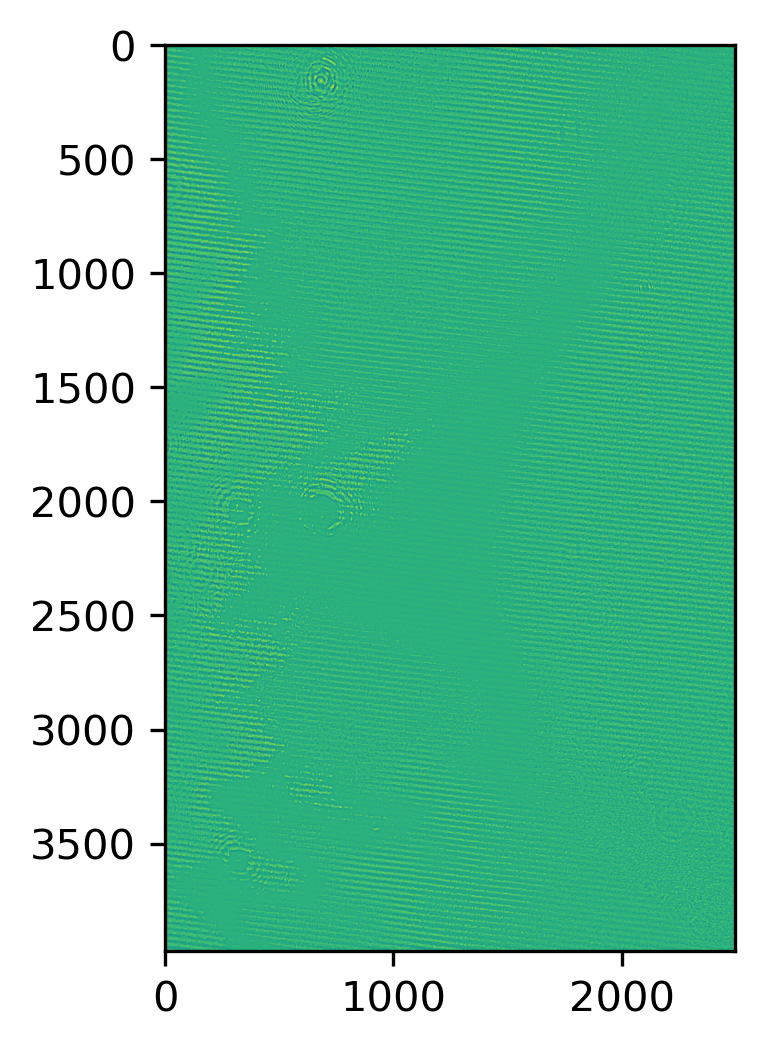

In [146]:
filt = filters.difference_of_gaussians(img, 1, 5)
plt.figure(dpi=300)
plt.imshow(filt)

# Column-wise Fourier Transforms
This is what's used in the paper to estimate frequencies. Our rows (indexed along first dimension) are in the x-direction, in-plane to the grating. The columns (second dimension) represent the z-direction as sampled by the tilted sensor.

Recall that in this non-paraxial limit, with $\lambda\approx d$ of the grating, we have

$$z_T = \frac{\lambda}{1-\sqrt{1-\frac{\lambda^2}{d^2}}}$$

(3970, 2495)


C:\Users\jade2\AppData\Local\Temp\ipykernel_4688\584462110.py:20: RuntimeWarning: divide by zero encountered in divide
  Talbot_lengths = 1 / frequencies


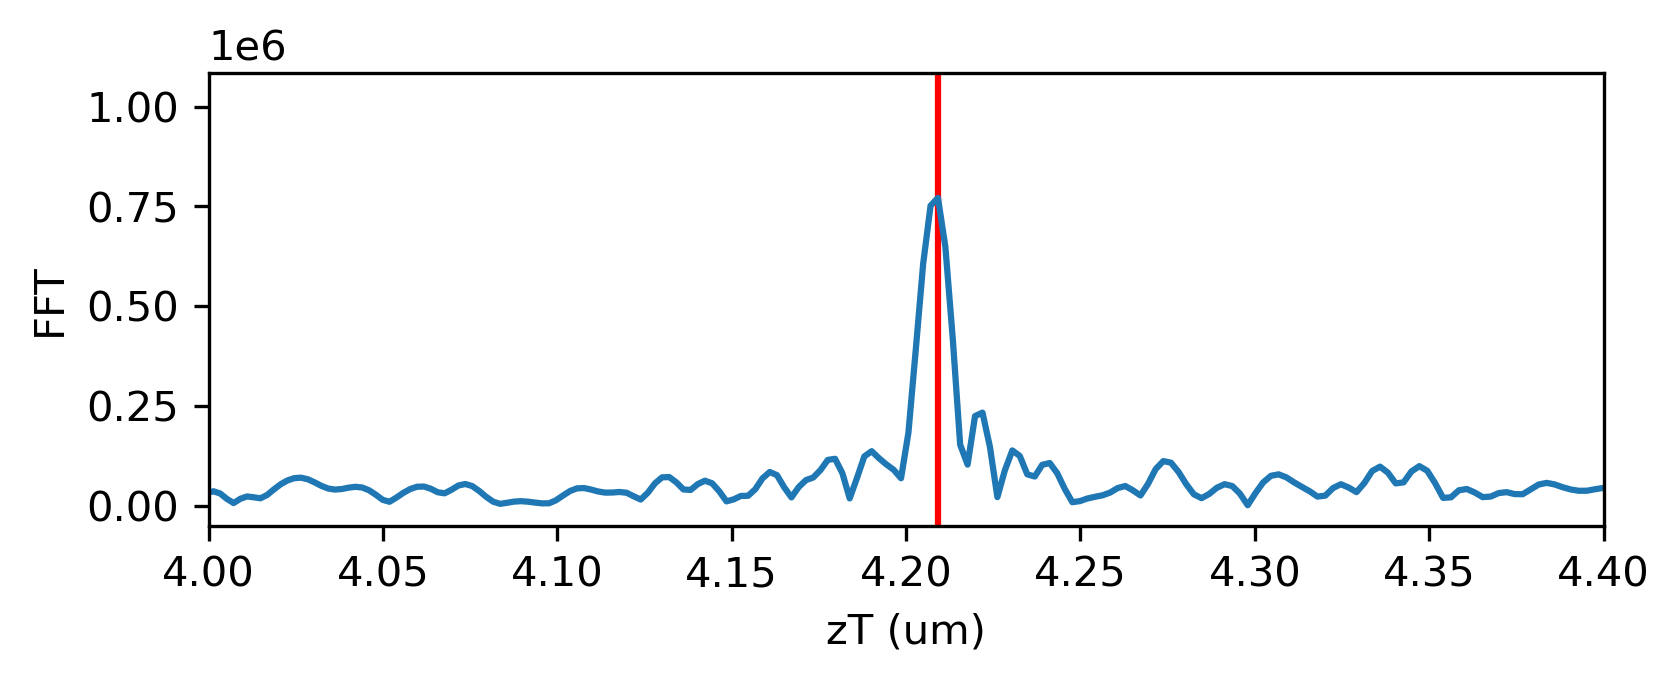

In [153]:
print(filt.shape)

# guess parameters
# lengths in microns
pix = 1.38 # pixel pitch
gratinglen = 1.2 # periodicity of grating
theta = 22.4 * np.pi / 180 # sensor tilt away from grating plane

# Compute the FFT per column
pad_factor = 4
FFT = np.zeros(filt.shape[0] * pad_factor)
for i in range(filt.shape[1]):
    sig = np.concatenate((filt[:, i], np.zeros(filt.shape[0] * (pad_factor-1)) ))
    fft = np.fft.fft(sig)
    FFT = FFT + fft
result = np.abs(FFT)

sampling_period = pix * np.sin(theta) # microns
frequencies = np.fft.fftfreq(FFT.shape[0], sampling_period) # spatial frequency in 1/microns of the Talbot pattern
Talbot_lengths = 1 / frequencies
#print(Talbot_lengths)

plt.figure(figsize=(6,2), dpi=300)

zT_632 = 0.6328 / (1-np.sqrt(1-0.6328**2/gratinglen**2))
plt.axvline(zT_632, color='r')

plt.plot(Talbot_lengths[1:len(Talbot_lengths)//2], result[1:len(Talbot_lengths)//2])
plt.xlabel('zT (um)')
plt.ylabel('FFT')

plt.xlim(4, 4.4)
plt.show()

C:\Users\jade2\AppData\Local\Temp\ipykernel_4688\250421442.py:2: RuntimeWarning: invalid value encountered in divide
  wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)


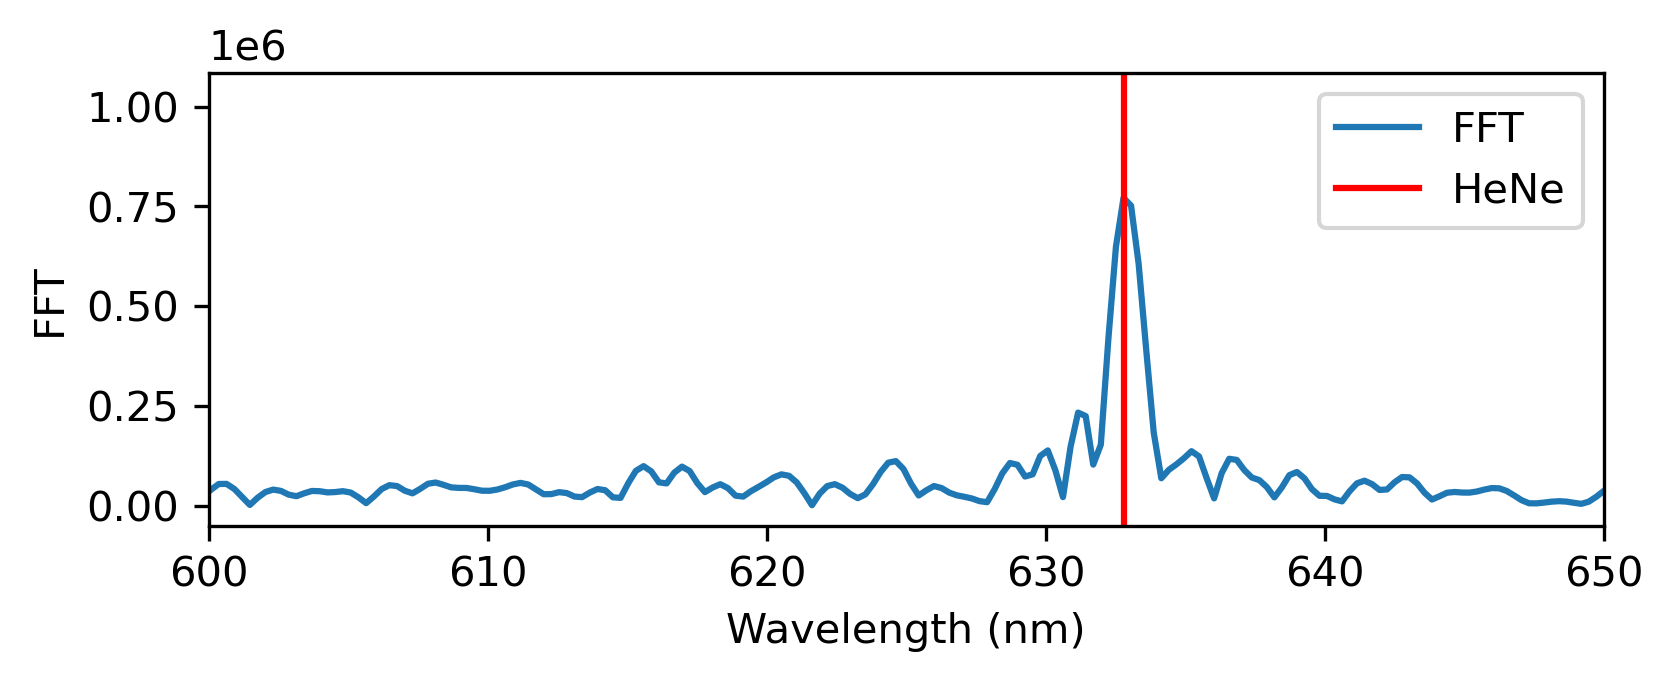

In [154]:
# Convert spatial frequency into wavelength of incident light
wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)
plt.figure(figsize=(6,2), dpi=300)
plt.xlim(600, 650)
plt.plot(wavelengths[1:len(Talbot_lengths)//2] * 1000, result[1:len(Talbot_lengths)//2], label='FFT')
plt.axvline(632.8, color='red', label='HeNe')
plt.xlabel("Wavelength (nm)")
plt.ylabel("FFT")
plt.legend()
plt.show()